# Notebook for Task3

## 0. Import the necessary libraries and get the data

In [97]:
import os   #helps me erase a warning that i am gettin
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler #i will use this to scale the data
from sklearn.decomposition import PCA #i will use this to reduce the dimensionality of the data
from sklearn.cluster import KMeans #i will use this to cluster the data
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
from time import time



os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #the names of the classes      

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



## 1. Scale and PCA transform the data

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test_pca shape: {X_test_pca.shape}")

X_train_pca shape: (50000, 103)
X_test_pca shape: (10000, 103)


## 2. Create Radial Basis Function Neural Network

### 2.1 Create device agnostic code


In [90]:
#run to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 2.2 Use Kmeans to find cluster centers, which act as RBF centers

In [92]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X_train_pca)
clusters = kmeans.cluster_centers_

### 2.3 Convert data to tensors and send them to device

In [93]:
X_train_pca_tensor = torch.from_numpy(X_train_pca).float()
X_train_pca_tensor = X_train_pca_tensor.to(device)

y_train_tensor = torch.from_numpy(y_train).long()
y_train_tensor = y_train_tensor.to(device)

X_test_pca_tensor = torch.from_numpy(X_test_pca).float()
X_test_pca_tensor = X_test_pca_tensor.to(device)

y_test_tensor = torch.from_numpy(y_test).long()
y_test_tensor = y_test_tensor.to(device)

### 2.4 Create helper functions





In [103]:
class my_Metrics:
    def __init__(self, epochs):
        self.epochs = epochs
        self.train_loss_values = np.full((epochs), np.nan)
        self.test_loss_values = np.full((epochs), np.nan)
        self.train_acc_values = np.full((epochs), np.nan)
        self.test_acc_values = np.full((epochs), np.nan)

    # def reset(self):
    #     self.train_loss_values[:] = np.nan
    #     self.test_loss_values[:] = np.nan
    #     self.train_acc_values[:] = np.nan
    #     self.test_acc_values[:] = np.nan

- train_test_model()

In [118]:
def train_test_model(model,X_train,y_train,X_test,y_test,epochs,metrics,lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    start_time = time()

    for epoch in range(epochs):
        # training
        model.train()

        # forward pass
        y_logits = model(X_train)
        train_preds = torch.argmax(y_logits, axis=1)

        # calculate the loss
        train_loss = loss_fn(y_logits, y_train)
        metrics.train_loss_values[epoch] = train_loss
        acc = accuracy_score(y_train_tensor.cpu().numpy(), train_preds.cpu().numpy())
        metrics.train_acc_values[epoch] = acc

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        train_loss.backward()

        # optimizer step
        optimizer.step()

        # testing
        # put the model in evaluation mode
        model.eval()
        with torch.inference_mode():
            # 1. forward pass
            y_logits = model(X_test)
            test_preds = torch.argmax(y_logits, axis=1)
            # 2. calculate the loss and accuracy
            test_loss = loss_fn(y_logits, y_test)
            metrics.test_loss_values[epoch] = test_loss
            test_acc = accuracy_score(y_test.cpu().numpy(), test_preds.cpu().numpy())
            metrics.test_acc_values[epoch] = test_acc

        # print the results
        if epoch % (epochs // 10) == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}, Train Accuracy: {acc*100:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc*100:.2f}%")

    print(f"Total time: {time() - start_time:.2f} seconds")
    return test_preds


    


- evaluate_model()

In [107]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

def evaluate_model(metrics,y_true,y_preds,target_names):
    print(classification_report(y_true.cpu().numpy(), y_preds.cpu().numpy(), target_names=target_names))

    plt.figure(figsize=(12, 8))
    plt.subplot(2,1,1)
    plt.plot(metrics.train_loss_values,label="Train Loss")
    plt.plot(metrics.test_loss_values,label="Test Loss")
    plt.title("Train Loss vs Test Loss" ,fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.plot(metrics.train_acc_values,label="Train Accuaracy")
    plt.plot(metrics.test_acc_values,label="Test Accuracy")
    plt.title("Train Accuracy vs Test Accuracy",fontsize=14,fontweight="bold")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy values")
    plt.grid(alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()



    

### 2.5 RBF Neural Network (v1)

- The following is a RBF Neural Network, with ONLY the weights and the biases of the final Linear Layer being trainable.
- The cluster centers and σ (the width of the RBFs) are fixed after initialization

$$
\text{RBF\_output}(x, c) = \exp\left(-\frac{\|x - c\|^2}{2\sigma^2}\right)
$$


$$
\sigma = \frac{d_{\text{max}}}{\sqrt{2K}}
$$
,where K is the number of the clusters


In [113]:
class mRBF_network1(nn.Module):
    def __init__(self,clusters,num_outputs):
        super().__init__()
        self.clusters = torch.from_numpy(clusters).to(device).float()
        self.n_clusters = clusters.shape[0]
        self.num_outputs = num_outputs

        pairwise_distances = torch.cdist(self.clusters, self.clusters, p=2)

        dmax = torch.max(pairwise_distances)

        # Convert n_clusters to tensor for computation, because torch.sqrt() only works on tensors
        self.sigma = dmax / torch.sqrt(2.0 * torch.tensor(self.n_clusters, dtype=torch.float32))

        # Define the RBF layer
        self.rbf_layer = nn.Linear(self.n_clusters, self.num_outputs)
        
        #sigma = dmax/sqrt(2K)

    def forward(self, X):
        # Calculate the RBF outputs for each cluster center
        rbf_outputs = torch.exp(-torch.cdist(X, self.clusters, p=2) ** 2 / (2 * self.sigma ** 2))
        #rbf_outputs = torch.exp(-torch.norm(X - self.clusters) ** 2 / (2 * self.sigma ** 2))
        # Pass the RBF outputs through the linear layer
        return self.rbf_layer(rbf_outputs)
        
        

      


In [114]:
epochs = 1000
model1 = mRBF_network1(clusters,len(class_names)).to(device)
model_metrics1 = my_Metrics(epochs)

test_preds = train_test_model(model1,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model_metrics1,lr=0.001)    

Epoch: 0 | Train Loss: 2.32373, Train Accuracy: 10.69% | Test Loss: 2.32338, Test Accuracy: 10.98%
Epoch: 100 | Train Loss: 2.28517, Train Accuracy: 11.51% | Test Loss: 2.28427, Test Accuracy: 11.90%
Epoch: 200 | Train Loss: 2.25622, Train Accuracy: 15.79% | Test Loss: 2.25509, Test Accuracy: 16.37%
Epoch: 300 | Train Loss: 2.23207, Train Accuracy: 18.61% | Test Loss: 2.23083, Test Accuracy: 18.89%
Epoch: 400 | Train Loss: 2.21133, Train Accuracy: 20.38% | Test Loss: 2.21005, Test Accuracy: 20.30%
Epoch: 500 | Train Loss: 2.19330, Train Accuracy: 21.59% | Test Loss: 2.19203, Test Accuracy: 21.67%
Epoch: 600 | Train Loss: 2.17750, Train Accuracy: 22.49% | Test Loss: 2.17626, Test Accuracy: 22.46%
Epoch: 700 | Train Loss: 2.16356, Train Accuracy: 23.13% | Test Loss: 2.16237, Test Accuracy: 22.97%
Epoch: 800 | Train Loss: 2.15119, Train Accuracy: 23.40% | Test Loss: 2.15004, Test Accuracy: 23.40%
Epoch: 900 | Train Loss: 2.14015, Train Accuracy: 23.72% | Test Loss: 2.13903, Test Accuracy:

              precision    recall  f1-score   support

    airplane       0.28      0.35      0.31      1000
  automobile       0.27      0.11      0.16      1000
        bird       0.22      0.14      0.17      1000
         cat       0.18      0.11      0.13      1000
        deer       0.25      0.44      0.32      1000
         dog       0.21      0.23      0.22      1000
        frog       0.19      0.10      0.13      1000
       horse       0.19      0.15      0.17      1000
        ship       0.39      0.31      0.34      1000
       truck       0.23      0.50      0.32      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.23     10000
weighted avg       0.24      0.24      0.23     10000



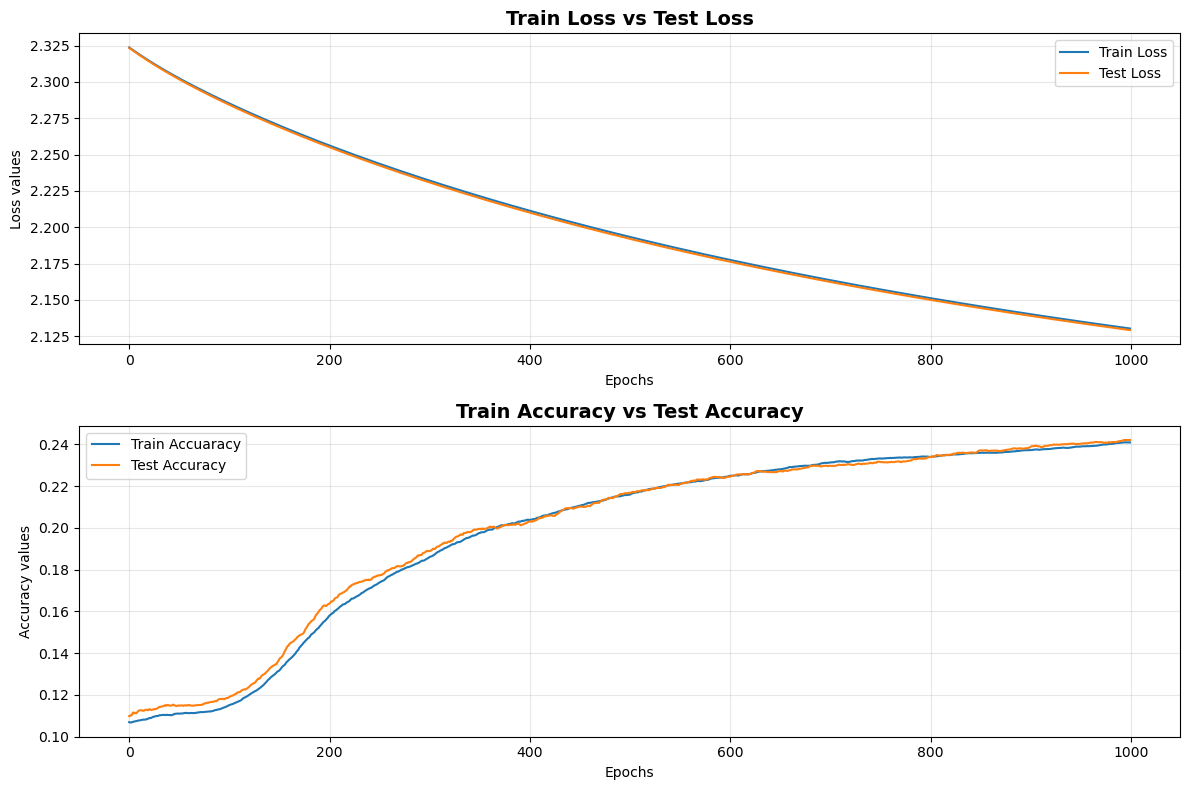

In [115]:
evaluate_model(model_metrics1,y_test_tensor,test_preds,class_names)

### Create RBF Neural Network (v2)

The difference between this RBF NN and the previous one, is that now the clusters and the σ are not fixed, but they are being trained like the weights and biases of the linear layer

In [116]:
class mRBF_network2(nn.Module):
    def __init__(self, clusters, num_outputs):
        super().__init__()
        # Initialize cluster centers as trainable parameters
        self.clusters = nn.Parameter(torch.from_numpy(clusters).to(device).float())
        self.n_clusters = clusters.shape[0]
        self.num_outputs = num_outputs

        # Initialize sigma as a trainable parameter
        pairwise_distances = torch.cdist(self.clusters, self.clusters, p=2)
        dmax = torch.max(pairwise_distances)
        self.sigma = nn.Parameter(dmax / torch.sqrt(2.0 * torch.tensor(self.n_clusters, dtype=torch.float32)))

        # Linear output layer
        self.rbf_layer = nn.Linear(self.n_clusters, self.num_outputs)

    def forward(self, X):
        # Calculate RBF activations
        rbf_outputs = torch.exp(-torch.cdist(X, self.clusters, p=2) ** 2 / (2 * self.sigma ** 2))
        # Pass through the linear output layer
        return self.rbf_layer(rbf_outputs)


In [120]:
epochs = 1000
model2 = mRBF_network2(clusters, len(class_names)).to(device)
model_metrics2 = my_Metrics(epochs)

test_preds = train_test_model(model2,X_train_pca_tensor,y_train_tensor,X_test_pca_tensor,y_test_tensor,epochs,model_metrics2,lr=0.001)

Epoch: 0 | Train Loss: 2.32621, Train Accuracy: 10.37% | Test Loss: 2.32632, Test Accuracy: 10.15%
Epoch: 100 | Train Loss: 2.28452, Train Accuracy: 12.96% | Test Loss: 2.28465, Test Accuracy: 12.58%
Epoch: 200 | Train Loss: 2.25727, Train Accuracy: 17.08% | Test Loss: 2.25710, Test Accuracy: 16.83%
Epoch: 300 | Train Loss: 2.23388, Train Accuracy: 18.50% | Test Loss: 2.23336, Test Accuracy: 18.61%
Epoch: 400 | Train Loss: 2.21250, Train Accuracy: 19.87% | Test Loss: 2.21168, Test Accuracy: 19.97%
Epoch: 500 | Train Loss: 2.19289, Train Accuracy: 20.93% | Test Loss: 2.19182, Test Accuracy: 20.78%
Epoch: 600 | Train Loss: 2.17495, Train Accuracy: 21.56% | Test Loss: 2.17370, Test Accuracy: 21.65%
Epoch: 700 | Train Loss: 2.15857, Train Accuracy: 22.14% | Test Loss: 2.15718, Test Accuracy: 22.19%
Epoch: 800 | Train Loss: 2.14359, Train Accuracy: 22.71% | Test Loss: 2.14210, Test Accuracy: 22.83%
Epoch: 900 | Train Loss: 2.12986, Train Accuracy: 23.07% | Test Loss: 2.12833, Test Accuracy:

              precision    recall  f1-score   support

    airplane       0.26      0.38      0.31      1000
  automobile       0.19      0.31      0.24      1000
        bird       0.23      0.06      0.09      1000
         cat       0.17      0.08      0.11      1000
        deer       0.21      0.23      0.22      1000
         dog       0.21      0.13      0.16      1000
        frog       0.24      0.38      0.30      1000
       horse       0.22      0.14      0.17      1000
        ship       0.37      0.26      0.30      1000
       truck       0.26      0.39      0.31      1000

    accuracy                           0.24     10000
   macro avg       0.23      0.24      0.22     10000
weighted avg       0.23      0.24      0.22     10000



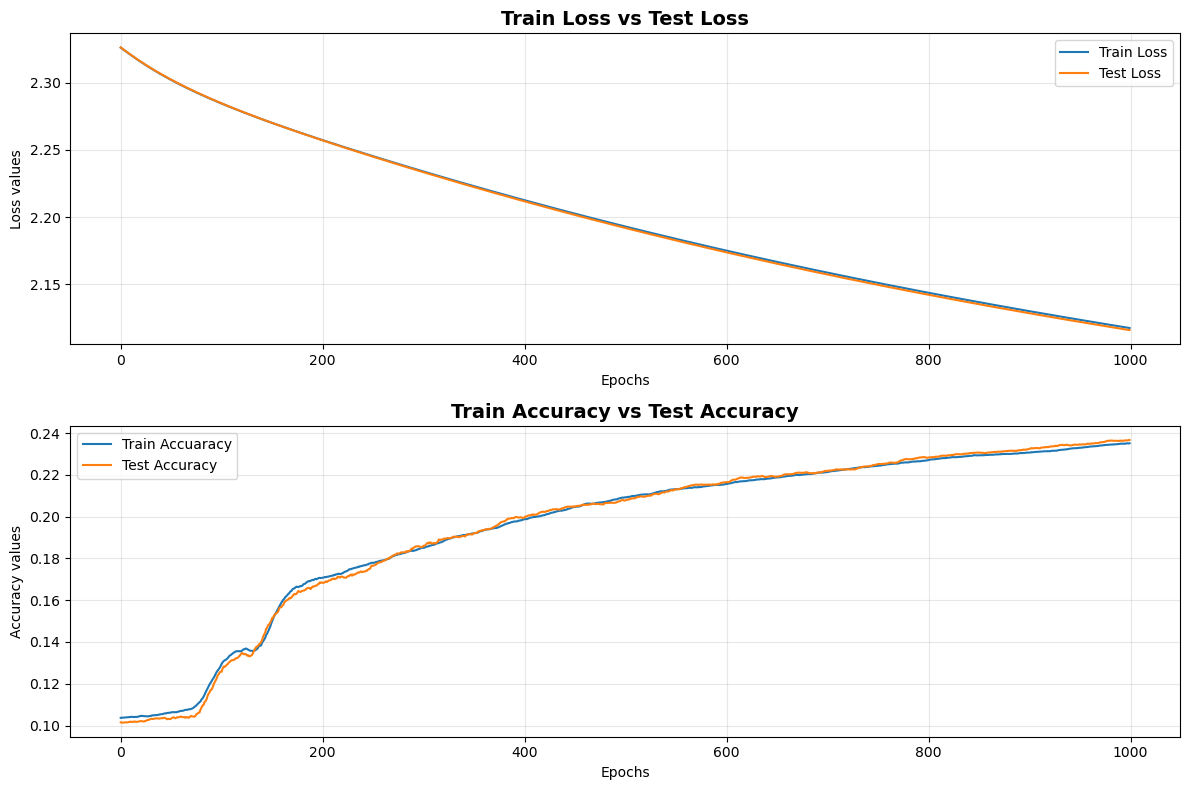

In [121]:
evaluate_model(model_metrics2,y_test_tensor,test_preds,class_names)